In [1]:
import pandas as pd
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import operator
import nltk
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


In [2]:
!python -m nltk.downloader punkt

/usr/local/lib/python3.9/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
!pip install vaderSentiment


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [4]:
adj_df = pd.read_csv('adjudicated.csv')
adj_df.head()

,ID,Adjudication,Classification,Text
0,0,Adjudicated,Pessimistic,But the hard truth is that not everyone is sha...
1,1,Adjudicated,Pessimistic,I understand -- I understand the sense of frus...
2,2,Adjudicated,Optimistic,"Now, what should happen when you make a mistak..."
3,3,Adjudicated,Pessimistic,"Mr. Speaker, Members, I rise today really with..."
4,4,Adjudicated,Neutral,"You know, we heard the horror stories about th..."


In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def get_sentiment_scores_feature(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_dict = analyzer.polarity_scores(text)
    return sentiment_dict['compound']


In [6]:
def lexical_diversity_feature(text):
    words = text.split()
    if len(words) == 0:  # To handle any empty strings
        return 0
    else:
        return len(set(words)) / len(words)

In [7]:
from textblob import TextBlob

def textblob_polarity_feature(text):
    return TextBlob(text).sentiment.polarity

In [9]:
def textblob_subjectivity_feature(text):
    return TextBlob(text).sentiment.subjectivity

In [10]:
pip install afinn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53447 sha256=31c287bd1f6a0aa9cfa17909b0e785cafd321618599f43fe7ad1bf00a1c056b1
  Stored in directory: /root/.cache/pip/wheels/79/91/ee/8374d9bc8c6c0896a2db75afdfd63d43653902407a0e76cd94
Successfully built afinn

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [13]:
from afinn import Afinn

def afinn_feature(text):
    return Afinn().score(text)

In [15]:
train_dev, test = train_test_split(adj_df, test_size=0.2, random_state=42)
train, dev = train_test_split(train_dev, test_size=0.25, random_state=42)

In [16]:
print("Training set size:", len(train))
print("Development set size:", len(dev))
print("Test set size:", len(test))

Training set size: 300
Development set size: 100
Test set size: 100


In [17]:
test_path = "splits/test.txt"
test.to_csv(test_path, sep='\t', index=False)
train_path = "splits/train.txt"
train.to_csv(train_path, sep='\t', index=False)
dev_path = "splits/dev.txt"
dev.to_csv(dev_path, sep='\t', index=False)

In [24]:
class Classifier:

    def __init__(self, trainX, trainY, devX, devY, testX, testY):
        self.feature_vocab = {}
        self.min_feature_count=2
        self.log_reg = None

        self.trainY=trainY
        self.devY=devY
        self.testY=testY
        
        self.trainX = self.process(trainX)
        self.devX = self.process(devX)
        self.testX = self.process(testX)

    def process(self, data):
        features = []
        for text in data:
            sentiment_scores = get_sentiment_scores_feature(text)
            subjectivity = textblob_subjectivity_feature(text)
            lexical_diversity_score = lexical_diversity_feature(text)
            polarity_score = afinn_feature(text)
            features.append([sentiment_scores, subjectivity, lexical_diversity_score, polarity_score])
        feature_columns = ['sentiment_score', 'subjectivity', 'lexical_diversity', 'polarity']
        df = pd.DataFrame(features, columns=feature_columns)
        return df
    
    # Train model and evaluate on held-out data
    def train(self):
        best_dev_accuracy=0
        best_model=None
        for C in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 5, 10, 25, 50, 75, 100]:
            self.log_reg = LogisticRegression(C = C, penalty='l2', max_iter=1000)
            self.log_reg.fit(self.trainX, self.trainY)
            training_accuracy = self.log_reg.score(self.trainX, self.trainY)
            development_accuracy = self.log_reg.score(self.devX, self.devY)
            if development_accuracy > best_dev_accuracy:
                best_dev_accuracy=development_accuracy
                best_model=self.log_reg
            print("C: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (C, training_accuracy, development_accuracy))
        self.log_reg=best_model
        print("Best Model: ", best_model)
        
    def test(self):
        print('Test Model: ', self.log_reg)
        return self.log_reg.score(self.testX, self.testY)
        
    def printWeights(self, n=10):
        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k
        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]
              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()
        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):
              weights=self.log_reg.coef_[i]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

In [36]:
from scipy.stats import norm

def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [43]:
def load_data(filename):
    X = []
    Y = []
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.split("\t")
            idd = cols[0]
            label = cols[2].lstrip().rstrip()
            text = cols[3]

            X.append(text)
            Y.append(label)

    return X[1:], Y[1:]

trainX, trainY = load_data(train_path)
devX, devY = load_data(dev_path)
testX, testY = load_data(test_path)

In [44]:
classifier = Classifier(trainX, trainY, devX, devY, testX, testY)
classifier.train()

C: 0.1, Train accuracy: 0.597, Dev accuracy: 0.500
C: 0.2, Train accuracy: 0.597, Dev accuracy: 0.500
C: 0.3, Train accuracy: 0.600, Dev accuracy: 0.500
C: 0.4, Train accuracy: 0.600, Dev accuracy: 0.500
C: 0.5, Train accuracy: 0.600, Dev accuracy: 0.500
C: 0.6, Train accuracy: 0.600, Dev accuracy: 0.500
C: 0.7, Train accuracy: 0.600, Dev accuracy: 0.500
C: 0.8, Train accuracy: 0.600, Dev accuracy: 0.500
C: 0.9, Train accuracy: 0.597, Dev accuracy: 0.500
C: 1, Train accuracy: 0.600, Dev accuracy: 0.500
C: 5, Train accuracy: 0.597, Dev accuracy: 0.500
C: 10, Train accuracy: 0.597, Dev accuracy: 0.500
C: 25, Train accuracy: 0.597, Dev accuracy: 0.500
C: 50, Train accuracy: 0.597, Dev accuracy: 0.500
C: 75, Train accuracy: 0.597, Dev accuracy: 0.500
C: 100, Train accuracy: 0.597, Dev accuracy: 0.500
Best Model:  LogisticRegression(C=0.1, max_iter=1000)


In [48]:
accuracy=classifier.test()
lower, upper=confidence_intervals(accuracy, len(testY), .95)
print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))
classifier.test()

Test Model:  LogisticRegression(C=0.1, max_iter=1000)
Test accuracy for best dev model: 0.610, 95% CIs: [0.514 0.706]

Test Model:  LogisticRegression(C=0.1, max_iter=1000)


0.61

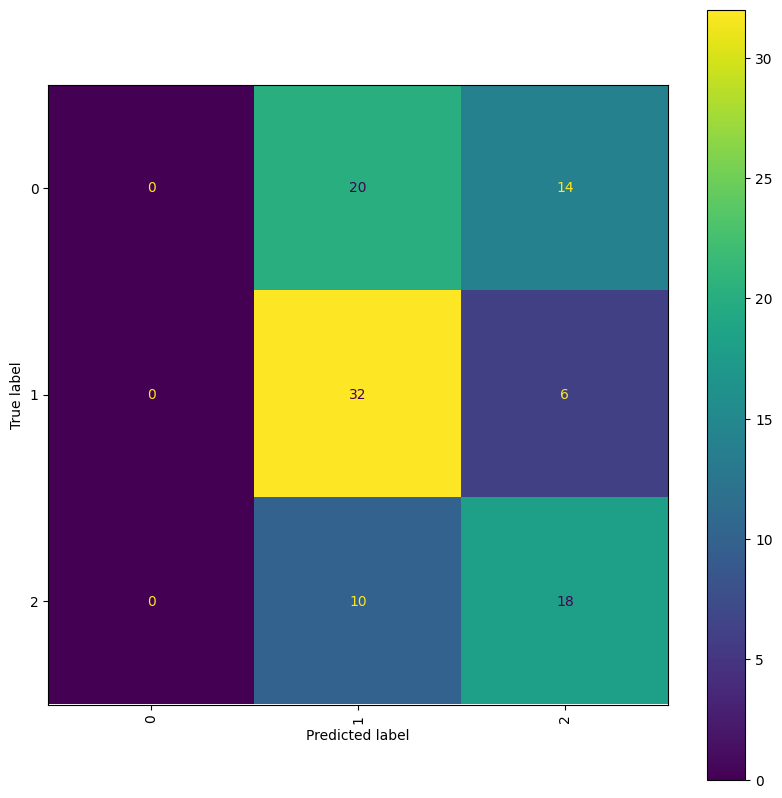

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def print_confusion(classifier):
    fig, ax = plt.subplots(figsize=(10,10))

    y_pred = classifier.log_reg.predict(classifier.devX)
    cm = confusion_matrix(classifier.devY, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, xticks_rotation="vertical", values_format="d")

    plt.show()

print_confusion(classifier)

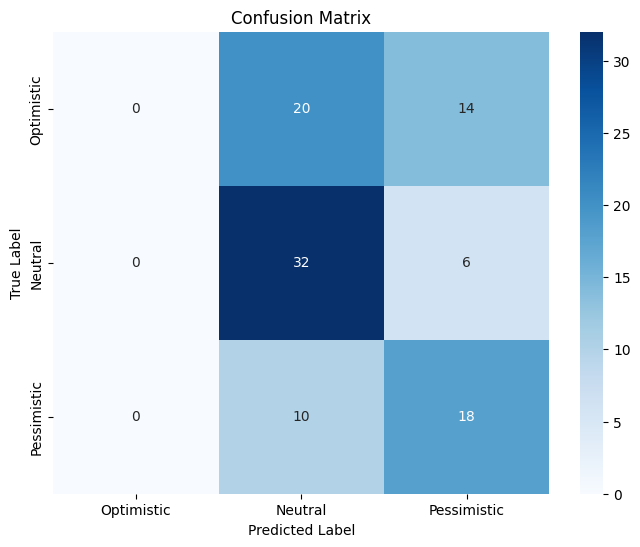

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class_labels = ["Optimistic", "Neutral", "Pessimistic"]

y_pred = classifier.log_reg.predict(classifier.devX)
conf_matrix = confusion_matrix(dev['Classification'], y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [56]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(trainY)
y_onehot_test = label_binarizer.transform(testY)
y_onehot_test.shape  # (n_samples, n_classes)

(100, 3)

[^1]: The code for the Multiple ROC curves comes from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [63]:
class_of_interest = "Optimistic"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

1

In [64]:
y_predd = classifier.log_reg.predict_proba(classifier.devX)

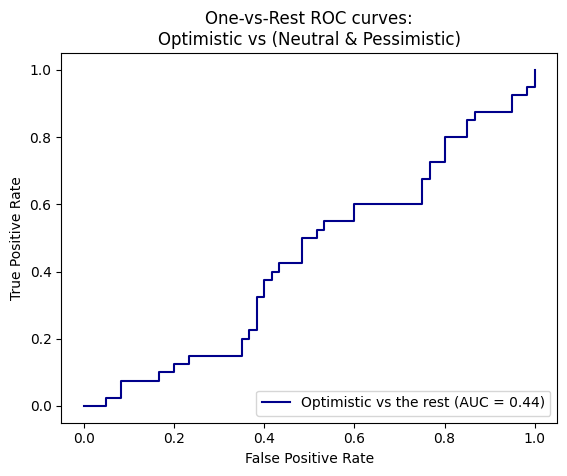

In [69]:
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_predd[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkblue",
    #plot_chance_level=True
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\nOptimistic vs (Neutral & Pessimistic)",
)

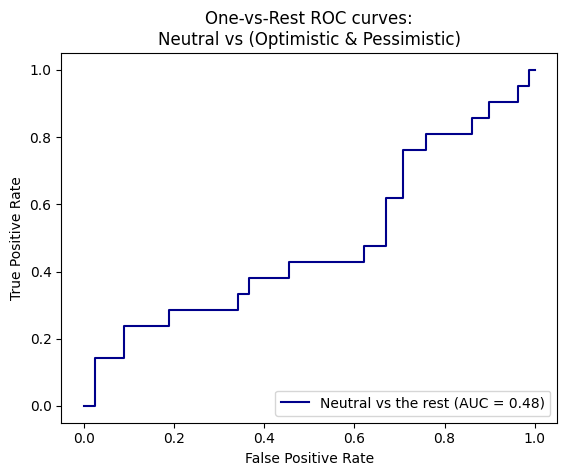

In [76]:
class_of_interestn = "Neutral"
class_idn = np.flatnonzero(label_binarizer.classes_ == class_of_interestn)[0]

display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_idn],
    y_predd[:, class_idn],
    name=f"{class_of_interestn} vs the rest",
    color="darkblue",
    #plot_chance_level=True
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\nNeutral vs (Optimistic & Pessimistic)",
)

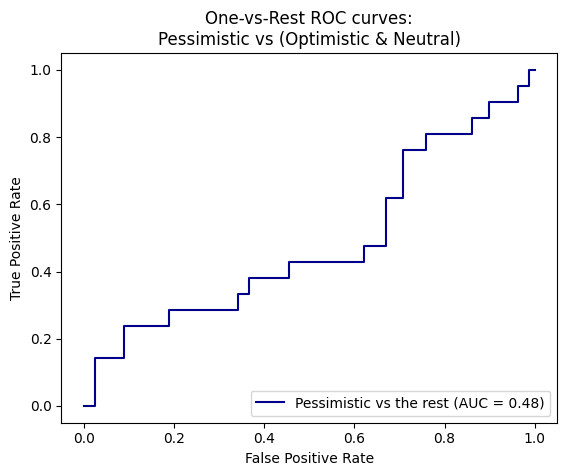

In [77]:
class_of_interestp = "Pessimistic"
class_idp = np.flatnonzero(label_binarizer.classes_ == class_of_interestn)[0]

display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_idp],
    y_predd[:, class_idp],
    name=f"{class_of_interestp} vs the rest",
    color="darkblue",
    #plot_chance_level=True
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\nPessimistic vs (Optimistic & Neutral)",
)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=71a8ee7d-3a4f-4c6b-b37d-002afa827510' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>